In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import warnings

warnings.simplefilter('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = (6, 4)

In [3]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SUBMIT_DATASET_PATH = './sample_submission.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
submit = pd.read_csv(SUBMIT_DATASET_PATH)
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

### Data fields

-    **Home Ownership** - домовладение
-    **Annual Income** - годовой доход
-    **Years in current job** - количество лет на текущем месте работы
-    **Tax Liens** - налоговые обременения
-    **Number of Open Accounts** - количество открытых счетов
-    **Years of Credit History** - количество лет кредитной истории
-    **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
-    **Number of Credit Problems** - количество проблем с кредитом
-    **Months since last delinquent** - количество месяцев с последней просрочки платежа
-    **Bankruptcies** - банкротства
-    **Purpose** - цель кредита
-    **Term** - срок кредита
-    **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
-    **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
-    **Monthly Debt** - ежемесячный долг
-    **Credit Score** - баллы кредитного рейтинга
-    **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


In [4]:
target_name = 'Credit Default'
cat_feature_names = [col for col in df_train.drop(target_name, axis=1).columns
                     if len(df_train[col].unique()) < 16]
print(f'Категориальные признаки: {cat_feature_names}')
num_feature_names = [col for col in df_train.drop(target_name, axis=1).columns
                     if col not in cat_feature_names]
print(f'Количественные признаки: {num_feature_names}')
selected_features = cat_feature_names + num_feature_names
print(f'Число признаков - {len(selected_features)}')

Категориальные признаки: ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']
Количественные признаки: ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
Число признаков - 16


### 1. EDA

In [5]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,"5,943.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","3,419.00","7,486.00","7,500.00","7,500.00","7,500.00","5,943.00","7,500.00"
mean,"1,366,391.72",0.03,11.13,18.32,"945,153.73",0.17,34.69,0.12,"11,873,177.45","289,833.24","18,314.45","1,151.09",0.28
std,"845,339.20",0.27,4.91,7.04,"16,026,216.67",0.50,21.69,0.35,"31,926,122.97","317,871.38","11,926.76","1,604.45",0.45
min,"164,597.00",0.00,2.00,4.00,0.00,0.00,0.00,0.00,"11,242.00",0.00,0.00,585.00,0.00
25%,"844,341.00",0.00,8.00,13.50,"279,229.50",0.00,16.00,0.00,"180,169.00","114,256.50","10,067.50",711.00,0.00
50%,"1,168,386.00",0.00,10.00,17.00,"478,159.00",0.00,32.00,0.00,"309,573.00","209,323.00","16,076.50",731.00,0.00
75%,"1,640,137.00",0.00,14.00,21.80,"793,501.50",0.00,50.00,0.00,"519,882.00","360,406.25","23,818.00",743.00,1.00
max,"10,149,344.00",7.00,43.00,57.70,"1,304,726,170.00",7.00,118.00,4.00,"99,999,999.00","6,506,797.00","136,679.00","7,510.00",1.00


Text(0.5, 1.0, 'Target Value Distribution')

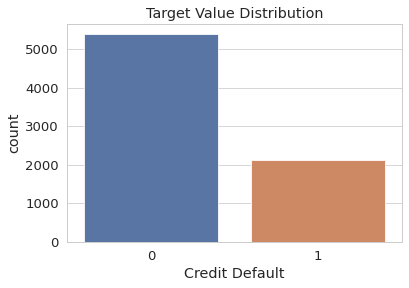

In [7]:
sns.countplot(x=target_name, data=df_train)
plt.title('Target Value Distribution')

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>],
       [<AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>]], dtype=object)

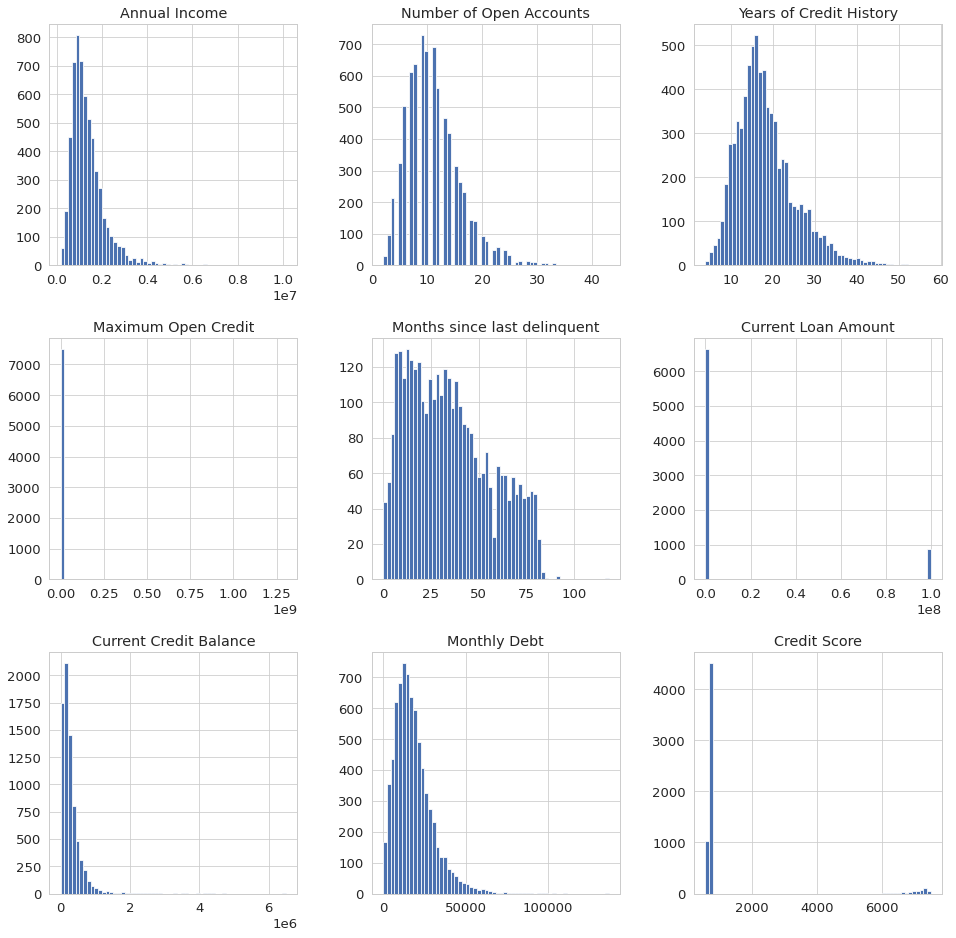

In [8]:
df_train[num_feature_names].hist(figsize=(16, 16), bins=60)


Согласно https://www.nerdwallet.com/article/finance/highest-credit-score максимальный рейтинг равен 850

<AxesSubplot:>

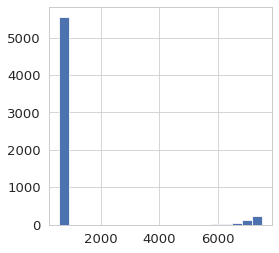

In [9]:
df_train['Credit Score'].hist(bins=20, figsize=(4, 4))

In [10]:
df_train.loc[df_train['Credit Score'] > 850, 'Credit Score'] = df_train['Credit Score'].median()


<AxesSubplot:>

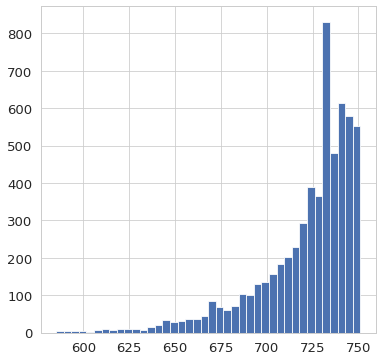

In [11]:
df_train['Credit Score'].hist(bins=40, figsize=(6, 6))

### Градация категориальных признаков

<AxesSubplot:xlabel='Bankruptcies', ylabel='count'>

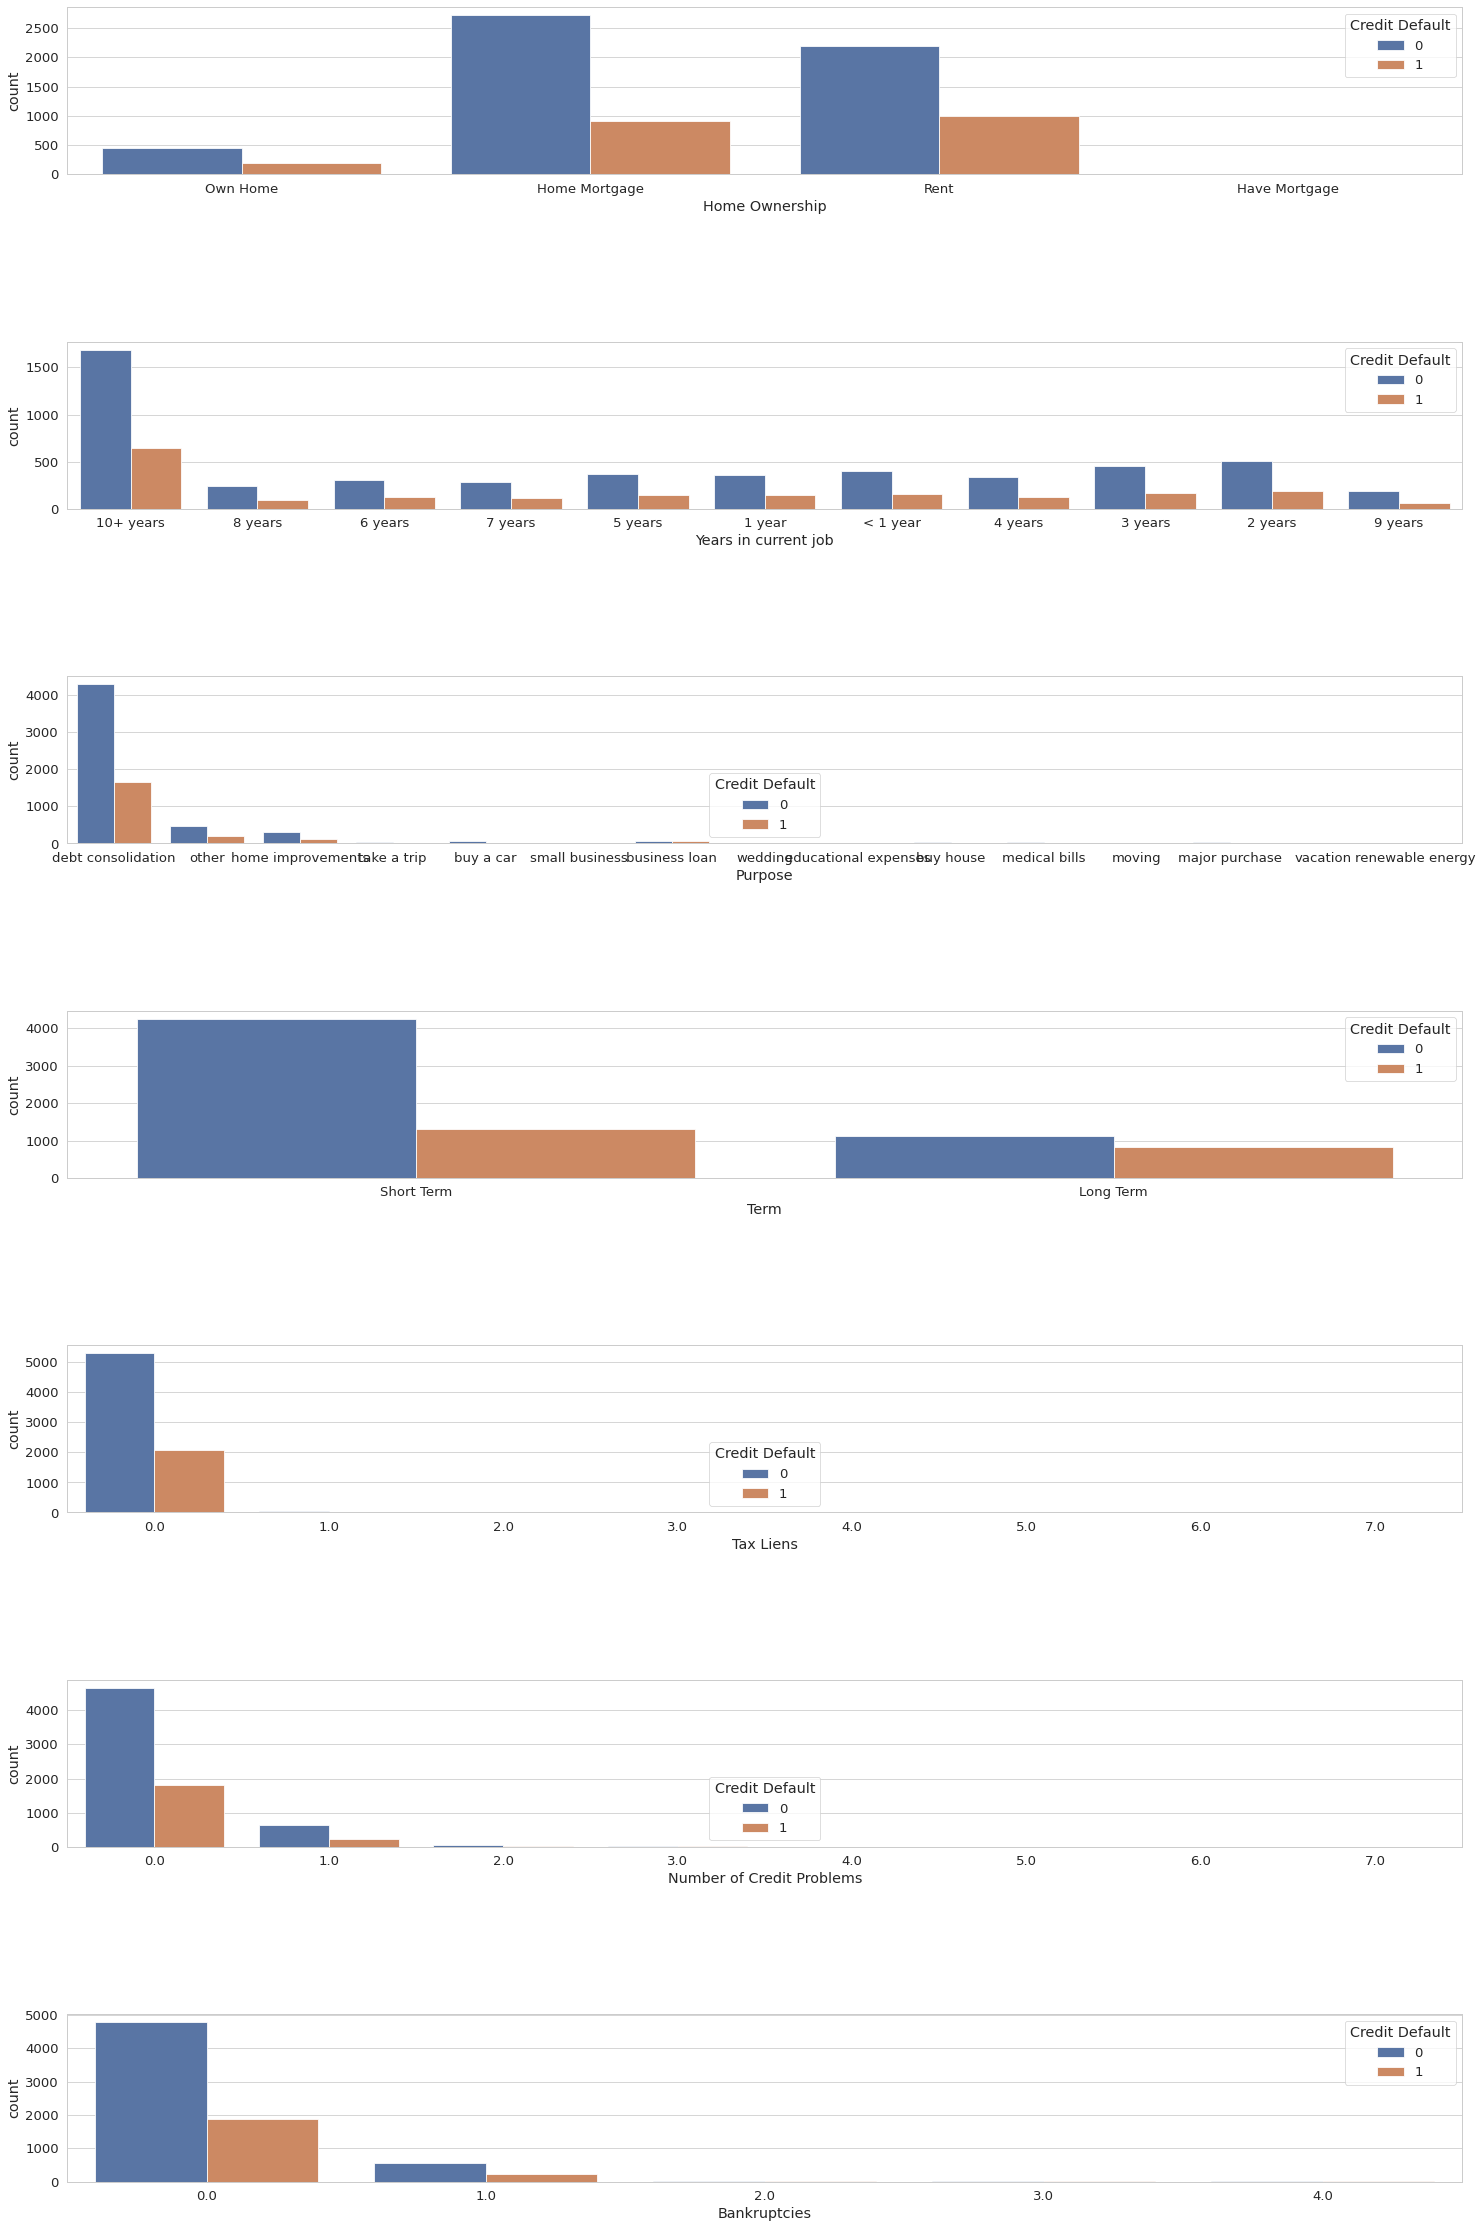

In [12]:
fig, ax = plt.subplots(nrows=7, figsize=(25, 40))

ax1, ax2, ax3, ax4, ax5, ax6, ax7 = ax.flatten()

fig.subplots_adjust(wspace=0.5, hspace=1)

sns.countplot(x='Home Ownership', hue=target_name, data=df_train, ax=ax1)
sns.countplot(x='Years in current job', hue=target_name, data=df_train, ax=ax2)
sns.countplot(x='Purpose', hue=target_name, data=df_train, ax=ax3)
sns.countplot(x='Term', hue=target_name, data=df_train, ax=ax4)
sns.countplot(x='Tax Liens', hue=target_name, data=df_train, ax=ax5)
sns.countplot(x='Number of Credit Problems', hue=target_name, data=df_train, ax=ax6)
sns.countplot(x='Bankruptcies', hue=target_name, data=df_train, ax=ax7)

In [13]:
def get_chi2(input_df, tg_name, field_name, unq_values=None):
    if unq_values is None:
        unq_values = []
    df = input_df.copy()
    df['ID'] = input_df.reset_index().index
    tmp_df = None
    if len(unq_values) == 0:
        tmp_df = df.loc[df[field_name].isin(df[field_name].unique()), ['ID', field_name, tg_name]]
    else:
        tmp_df = df.loc[df[field_name].isin(unq_values), ['ID', field_name, tg_name]]
    table = tmp_df.pivot_table(values='ID', index=field_name, columns=tg_name, aggfunc='count')
    table.fillna(0, inplace=True)

    chi2, p, dof, excepted = chi2_contingency(table, correction=False)
    return p

### Выделим похожие распределения по полям. По критерию хи квадрат уберём неподходящие

In [14]:
for cat in cat_feature_names:
    chi2 = get_chi2(df_train, target_name, cat)
    if chi2 > .05:
        print(f'{cat} = {chi2}')


Years in current job = 0.9984533399948599
Tax Liens = 0.0833008990757624
Bankruptcies = 0.8413658230717415


### Обработка данных

In [15]:
class DataPreprocessing:

    def __init__(self):
        self.medians = None
        self.modes = None
        self.max_score = 850

    def fit(self, X):
        """Сохранение статистик"""
        X = X.copy()
        # Расчет медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]

    def transform(self, X):
        """Трансформация данных"""
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace = True)
        X.loc[X['Credit Score'] > 850, 'Credit Score'] = X['Credit Score'].median()


        X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)


        X['Months since last delinquent'].fillna(self.medians['Months since last delinquent'], inplace = True)


        X['Bankruptcies'].fillna(0, inplace=True)

        X['Years in current job'].fillna(0, inplace=True)


        X['Number of Credit Problems'] = X['Number of Credit Problems'].astype('str')

        for col in X.columns:
            if X[col].dtype == 'float64':
                X[col] = X[col].astype('int')

        return X


In [16]:
feature_names = [
    'Current Loan Amount',
    'Credit Score',
    'Annual Income',
    'Years of Credit History',
    'Monthly Debt',
    'Months since last delinquent',
    'Maximum Open Credit',
    'Current Credit Balance'
]

cat_feature_names = [
    'Term',
    'Number of Credit Problems',
    'Home Ownership',
    'Purpose',
]

In [17]:
X = df_train.drop(columns=target_name)
y = df_train[target_name]

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)


In [19]:

preprocessor = DataPreprocessing()
preprocessor.fit(X_train)  #  fit применяем только к X_train

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)


In [20]:
X_train = X_train[feature_names + cat_feature_names]
X_valid = X_valid[feature_names + cat_feature_names]
df_test = df_test[feature_names + cat_feature_names]

### Построение модели

In [21]:
X_train.dtypes

Current Loan Amount              int64
Credit Score                     int64
Annual Income                    int64
Years of Credit History          int64
Monthly Debt                     int64
Months since last delinquent     int64
Maximum Open Credit              int64
Current Credit Balance           int64
Term                            object
Number of Credit Problems       object
Home Ownership                  object
Purpose                         object
dtype: object

In [22]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

baseline = catb.CatBoostClassifier(
    iterations=100,
    early_stopping_rounds=20,
    nan_mode='Min',
    silent=True,
    random_state=42
)
baseline.fit(X_train, y_train,
             cat_features=cat_feature_names,
             eval_set=(X_valid, y_valid)
             )

y_train_pred = baseline.predict(X_train)
y_valid_pred = baseline.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      3631
           1       0.77      0.35      0.48      1394

    accuracy                           0.79      5025
   macro avg       0.78      0.65      0.67      5025
weighted avg       0.79      0.79      0.76      5025

TEST

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1756
           1       0.71      0.29      0.41       719

    accuracy                           0.76      2475
   macro avg       0.74      0.62      0.63      2475
weighted avg       0.75      0.76      0.72      2475



In [23]:
feature_importances = pd.DataFrame(zip(X_train.columns, baseline.feature_importances_),
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Credit Score,33.53
0,Current Loan Amount,20.76
2,Annual Income,15.52
8,Term,8.20
6,Maximum Open Credit,4.62
4,Monthly Debt,4.56
7,Current Credit Balance,4.12
10,Home Ownership,2.36
3,Years of Credit History,2.13
5,Months since last delinquent,1.73


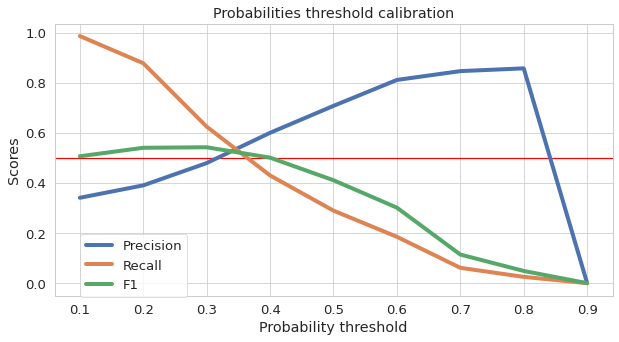

In [24]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    figure = plt.figure(figsize=(10, 5))

    plt1 = figure.add_subplot(111)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))


y_valid_proba = baseline.predict_proba(X_valid)[:, 1]
show_proba_calibration_plots(y_valid_proba, y_valid)

In [25]:
y_valid_pred = np.array(y_valid_proba > 0.33, dtype=int)
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      3631
           1       0.77      0.35      0.48      1394

    accuracy                           0.79      5025
   macro avg       0.78      0.65      0.67      5025
weighted avg       0.79      0.79      0.76      5025

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1756
           1       0.52      0.56      0.54       719

    accuracy                           0.72      2475
   macro avg       0.66      0.67      0.67      2475
weighted avg       0.73      0.72      0.72      2475



In [26]:

baseline.fit(X_train, y_train,
             cat_features=cat_feature_names
             )

y_test_pred = baseline.predict_proba(df_test)[:, 1]
y_test_pred = np.array(y_test_pred > 0.33, dtype=int)

submit['Credit Default'] = y_test_pred
submit.to_csv('./baseline_catboost_predictions.csv', index=False)
